In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate
from skimage.transform import resize
from monai.networks.nets.basic_unet import BasicUnet

from scripts.run_test import get_overlay
from utils.tools import load_checkpoint, mask_to_bbox_v2
from data.multi_label_image_dataset import Image_Dataset
from preprocessing.organ_labels_v2 import selected_organ_labels

/home/eytan/miniconda3/envs/label/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
test_data_file_path = '/home/eytan/storage/staff/eytankats/data/nako_10k/masks_projection_v2/test_masks_filtered_info.csv'
images_dir = '/home/eytan/storage/staff/eytankats/data/nako_10k/images_depth/'
masks_dir = '/home/eytan/storage/staff/eytankats/data/nako_10k/masks_projection_v2/'
ckpt_path = '/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/202505141433_multilabel_basicunet_filteredaggmasksv2/checkpoints/best_valid_loss.pth'

In [3]:
df = pd.read_csv('/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/202505141433_multilabel_basicunet_filteredaggmasksv2/results.csv')[:-2]
df['experiment'] = 'multilabel_basicunet_filteredaggmasksv2'

In [4]:
def plot_results(data, columns, labels, title, aspect_ratio=1, outliers=False):

    df_filtered = data[data.columns.intersection(columns)]
    df_melted = pd.melt(df_filtered, "experiment")

    sns.set_theme(style="whitegrid")
    g = sns.catplot(kind='box', data=df_melted, x='variable', y='value', hue='experiment', height=6, aspect=aspect_ratio, legend=False, whis=(5, 95), width=.75, showfliers=outliers)
    # g.set(ylim=(-70, 70))
    g.set(xlabel='', ylabel='detection offset error (mm)', title=title)
    g.set_xticklabels(labels, rotation=90)

In [5]:
print(tabulate(df.tail(10), headers='keys', tablefmt='psql'))

+-----+------------+-------------+--------------+-----------------+-----------------+---------------+----------------+-------------------+-------------------+---------------------+----------------------+-------------------------+-------------------------+--------------------+---------------------+------------------------+------------------------+--------------+---------------+------------------+------------------+----------------+-----------------+--------------------+--------------------+-----------------+------------------+---------------------+---------------------+-----------------------------+------------------------------+---------------------------------+---------------------------------+-----------------------------+------------------------------+---------------------------------+---------------------------------+------------------------------+-------------------------------+----------------------------------+----------------------------------+-------------------------------+--

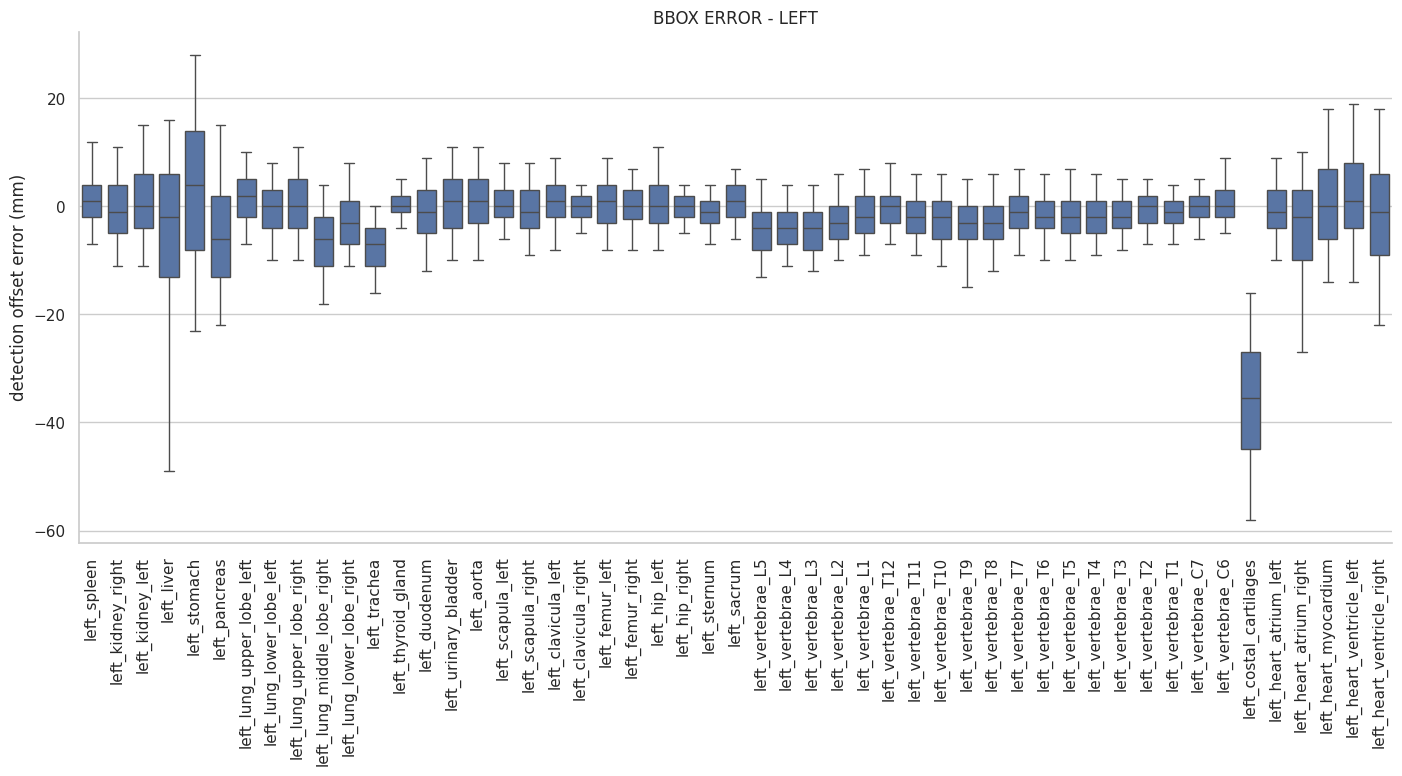

In [6]:
all_labels = [col for col in df.columns if col.startswith('left') and ('mean' not in col)]
all_cols = [col for col in df.columns if col.startswith('left') and ('mean' not in col)]
all_cols.append('experiment')
plot_results(df, all_cols, all_labels, "BBOX ERROR - LEFT", aspect_ratio=2.5)

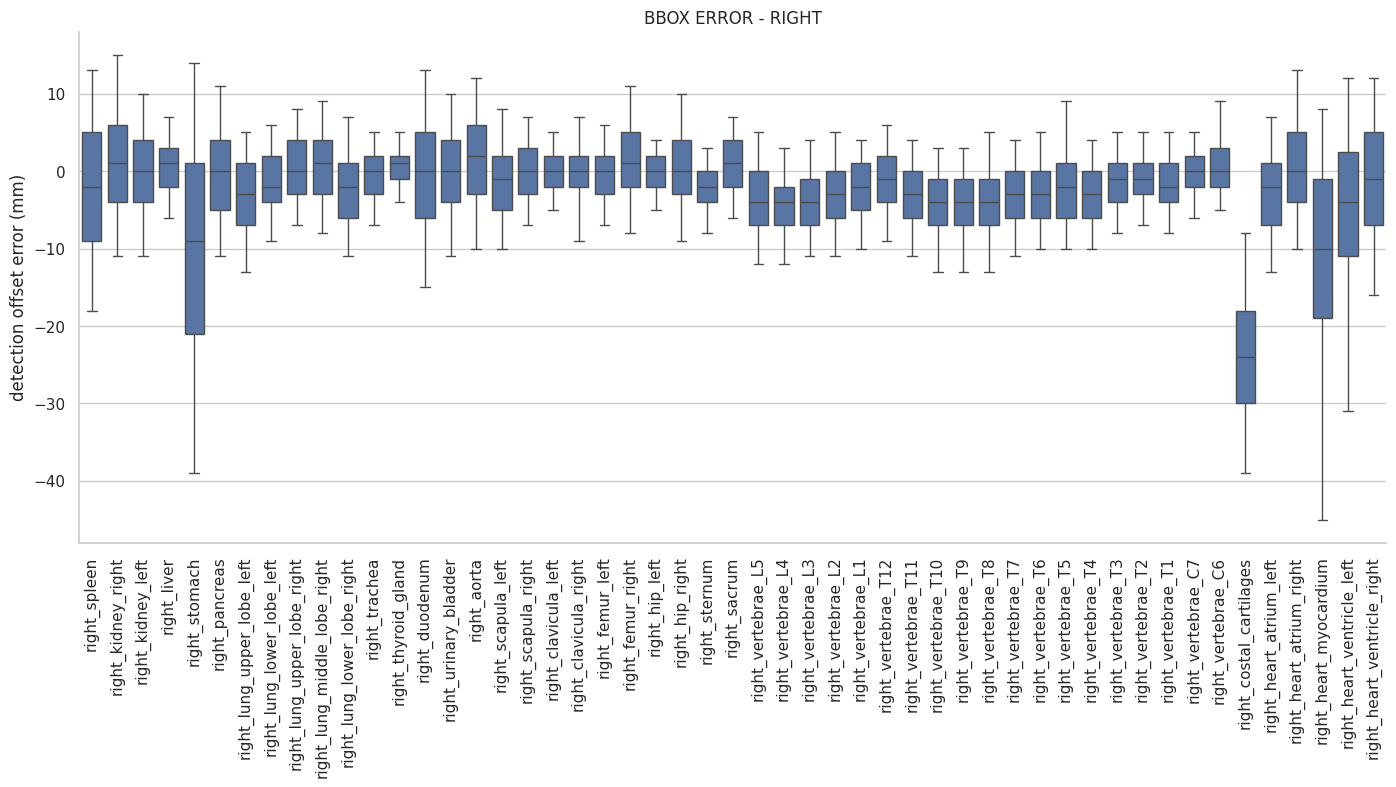

In [7]:
all_labels = [col for col in df.columns if col.startswith('right') and ('mean' not in col)]
all_cols = [col for col in df.columns if col.startswith('right') and ('mean' not in col)]
all_cols.append('experiment')
plot_results(df, all_cols, all_labels, "BBOX ERROR - RIGHT", aspect_ratio=2.5)

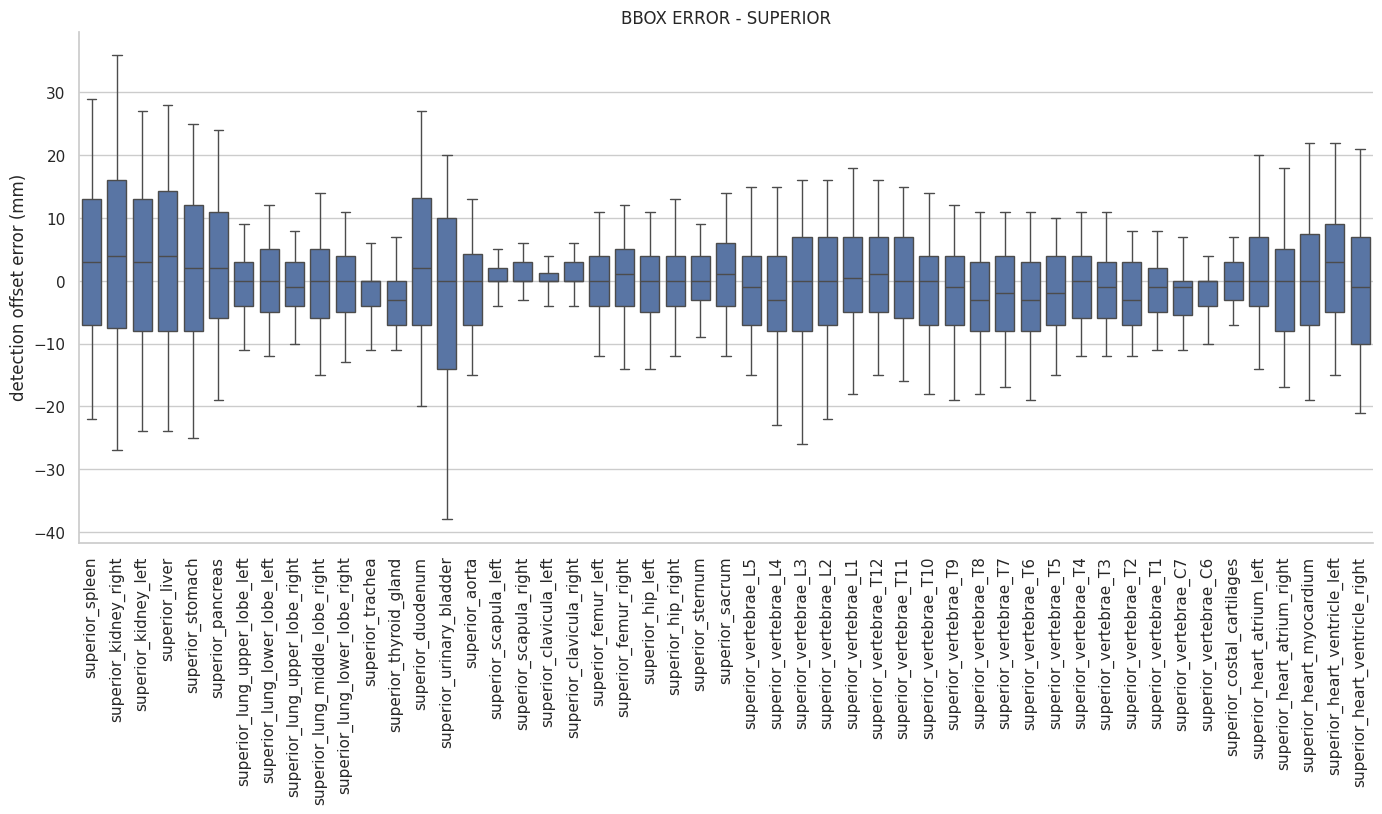

In [8]:
all_labels = [col for col in df.columns if col.startswith('superior') and ('mean' not in col)]
all_cols = [col for col in df.columns if col.startswith('superior') and ('mean' not in col)]
all_cols.append('experiment')
plot_results(df, all_cols, all_labels, "BBOX ERROR - SUPERIOR", aspect_ratio=2.5)

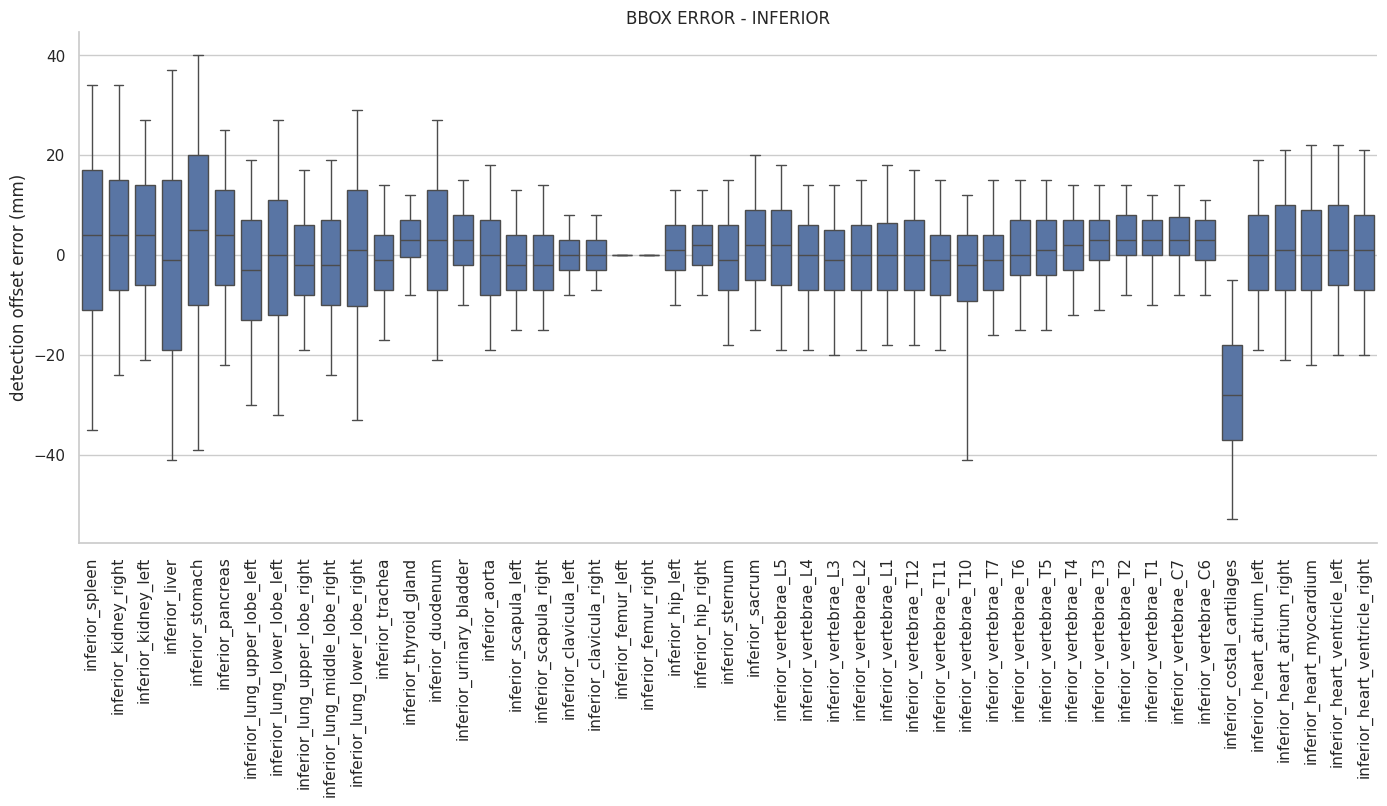

In [9]:
all_labels = [col for col in df.columns if col.startswith('inferior') and ('mean' not in col) and ('T8' not in col) and ('T9' not in col)]
all_cols = [col for col in df.columns if col.startswith('inferior') and ('mean' not in col) and ('T8' not in col) and ('T9' not in col)]
all_cols.append('experiment')
plot_results(df, all_cols, all_labels, "BBOX ERROR - INFERIOR", aspect_ratio=2.5)

In [6]:
# Initialize dataset and model
test_dataset = Image_Dataset(test_data_file_path, images_dir=images_dir, masks_dir=masks_dir, stage='test')

model = BasicUnet(spatial_dims=2, in_channels=3, out_channels=len(selected_organ_labels), dropout=False)
model = load_checkpoint(model, ckpt_path)

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [7]:
def visualize_results(sample, anatomy):

    anatomy_idx = selected_organ_labels.index(anatomy)
    data_idx = test_dataset.name_list.index(sample)
    data = test_dataset[data_idx]

    img_rgb = data['img'].unsqueeze(0)

    if (img_rgb == 0).all():
        return

    img_rgb = img_rgb / 255.0
    img_rgb = 2. * img_rgb - 1.

    seg_img = []
    for data in data['seg']:
        seg_raw = data.unsqueeze(0)
        seg_raw = seg_raw.permute(0, 3, 1, 2) / 255.0
        seg_raw[seg_raw > 0.] = 1.

        seg_img.append(torch.mean(seg_raw, dim=1, keepdim=False))
    seg_img = torch.stack(seg_img, dim=1).cuda()


    with torch.no_grad():
        pred_seg = torch.nn.functional.sigmoid(model(img_rgb))

    seg_anatomy = resize(seg_img[0, anatomy_idx, :, :].detach().cpu().numpy(), (480, 948), order=0, mode='constant')
    pred_anatomy = resize(pred_seg[0, anatomy_idx, :, :].detach().cpu().numpy(), (480, 948), order=1, mode='constant')
    pred_anatomy_thr = np.float32(pred_anatomy > 0.5)

    bbox_seg = mask_to_bbox_v2(seg_anatomy)
    bbox_pred = mask_to_bbox_v2(pred_anatomy > 0.5)

    if bbox_seg is not None and bbox_pred is not None:
        posterior_anatomy = bbox_seg['x1'] - bbox_pred['x1']
        right_anatomy =  bbox_seg['y1'] - bbox_pred['y1']
        superior_anatomy = bbox_pred['x2'] - bbox_seg['x2']
        left_anatomy = bbox_pred['y2'] - bbox_seg['y2']
    else:
        left_anatomy = np.nan
        right_anatomy = np.nan
        superior_anatomy = np.nan
        posterior_anatomy = np.nan

    bbox_seg = mask_to_bbox_v2(np.rot90(seg_anatomy))
    bbox_pred = mask_to_bbox_v2(np.uint8(np.rot90(pred_anatomy) > 0.5))

    img_to_plot = np.uint8(np.rot90(resize((img_rgb[0].permute(1, 2, 0).cpu().detach().numpy() + 1) / 2, (480, 948), order=1, mode='constant')) * 255)
    seg_to_plot = np.uint8(np.rot90(seg_anatomy) * 255)
    pred_to_plot_thr = np.uint8(np.rot90(pred_anatomy_thr) * 255)

    overlay_to_plot = np.uint8(get_overlay(img_to_plot, seg_to_plot, np.zeros_like(seg_to_plot)))
    overlay_to_plot_thr = np.uint8(get_overlay(img_to_plot, seg_to_plot, pred_to_plot_thr))

    seg_to_plot_rgb = np.zeros_like(img_to_plot)
    seg_to_plot_rgb[:, :, 0] = seg_to_plot
    seg_to_plot_rgb[:, :, 1] = seg_to_plot
    seg_to_plot_rgb[:, :, 2] = seg_to_plot

    # Image with predicted bbox drawn
    img_with_pred_bbox = overlay_to_plot.copy()
    if bbox_pred is not None:
        cv2.rectangle(img_with_pred_bbox, (bbox_pred['x1'], bbox_pred['y1']), (bbox_pred['x2'], bbox_pred['y2']), (0, 255, 0), 3)
    if bbox_seg is not None:
        cv2.rectangle(img_with_pred_bbox, (bbox_seg['x1'], bbox_seg['y1']), (bbox_seg['x2'], bbox_seg['y2']), (255, 0, 0), 3)

    stacked_img = np.concatenate((img_to_plot, seg_to_plot_rgb, overlay_to_plot_thr, img_with_pred_bbox), axis=1)

    plt.figure(figsize=(8, 15))
    plt.imshow(stacked_img)
    plt.grid(False)
    plt.title(f'left: {left_anatomy}\nright: {right_anatomy}\nsuperior: {superior_anatomy}\ninferior: {posterior_anatomy}')

/tmp/ipykernel_3024309/3110510701.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 15))


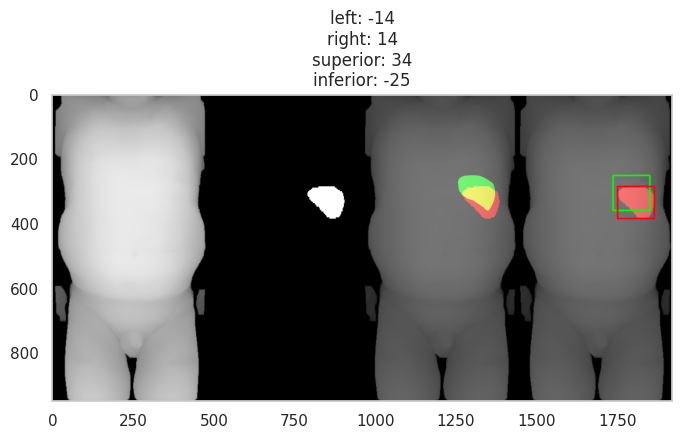

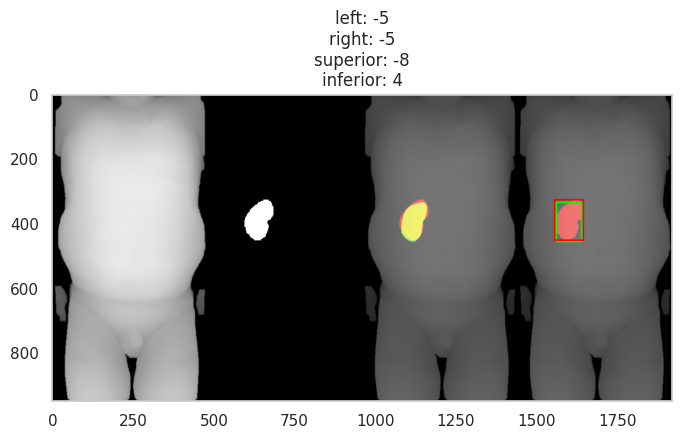

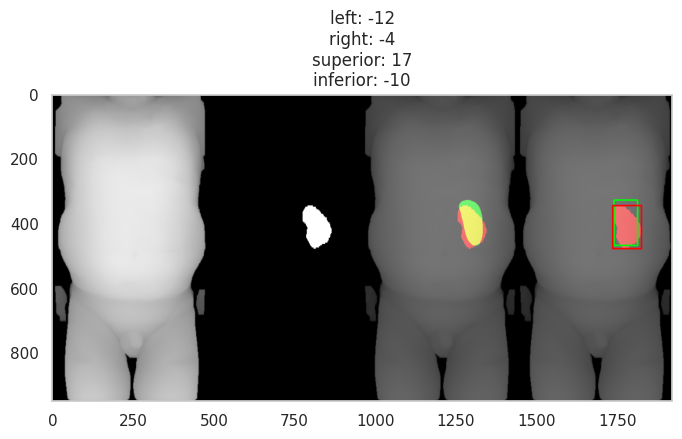

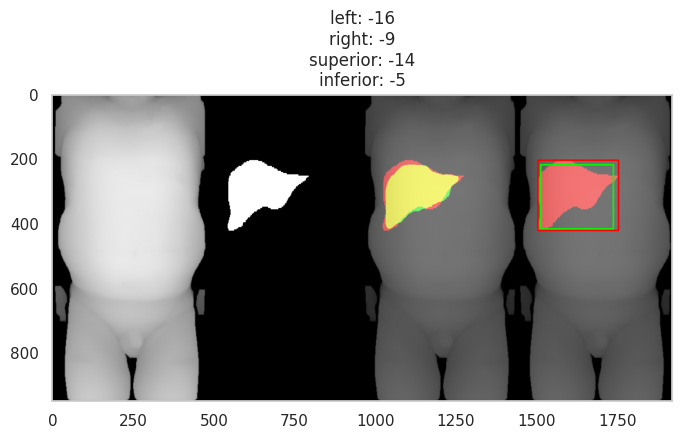

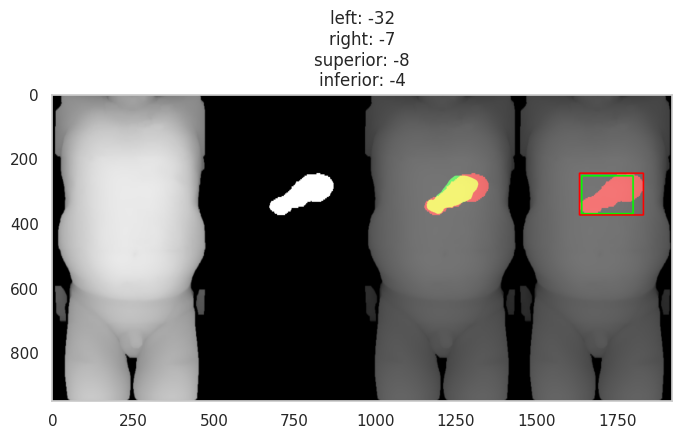

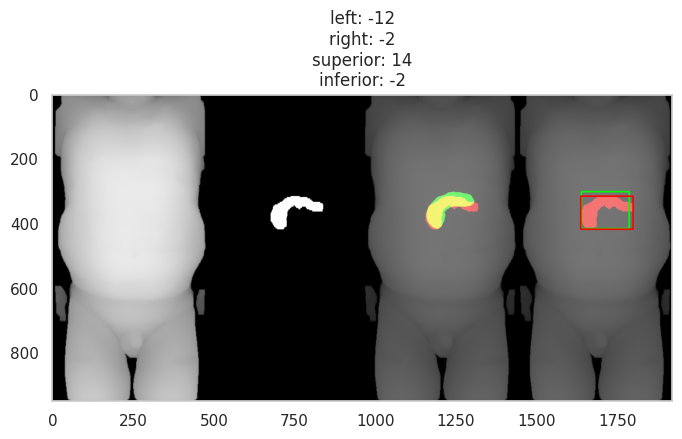

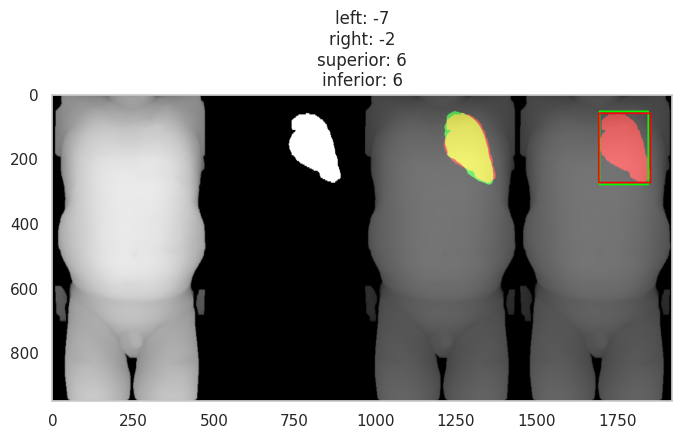

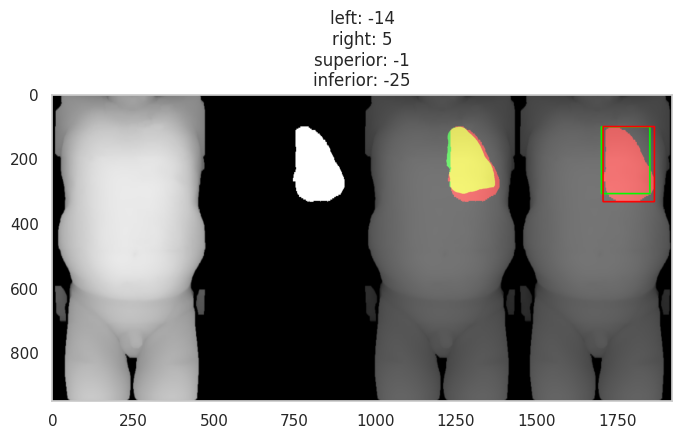

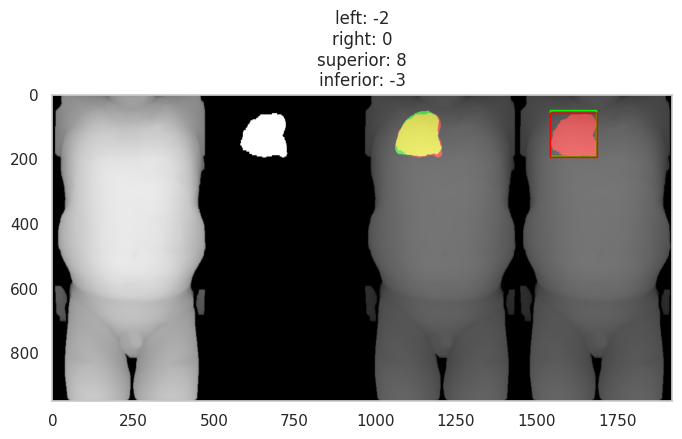

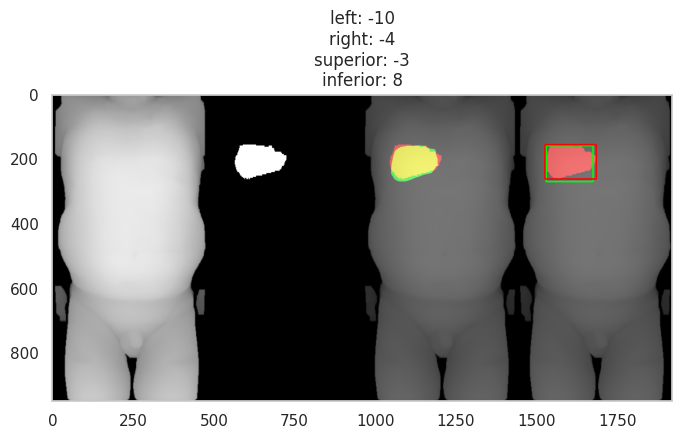

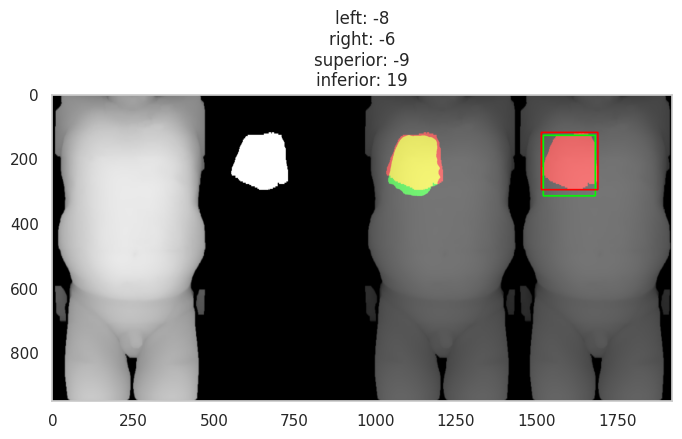

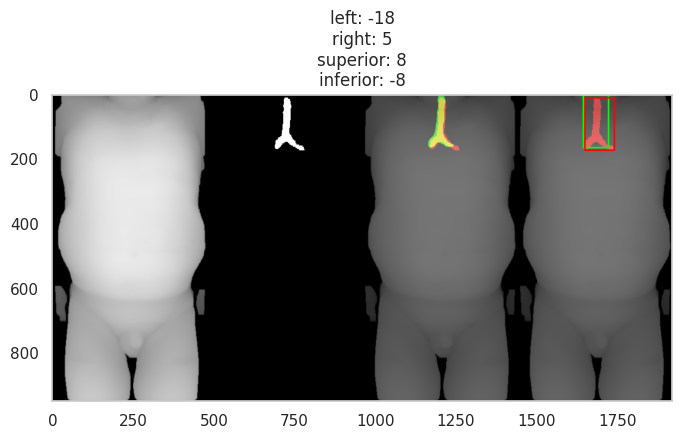

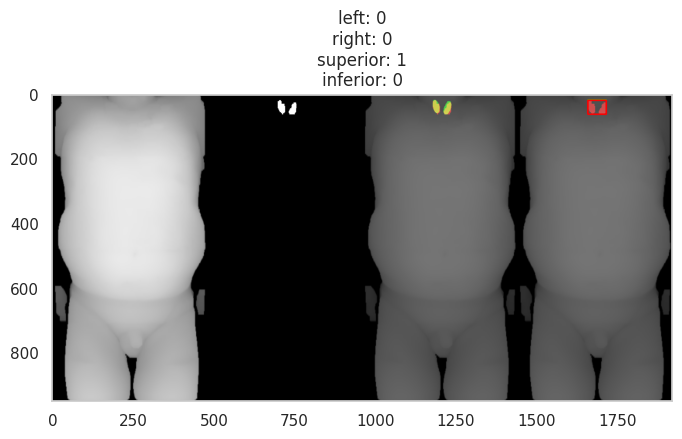

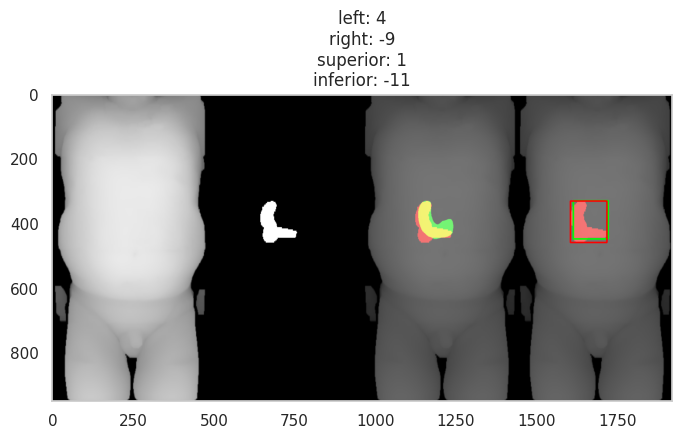

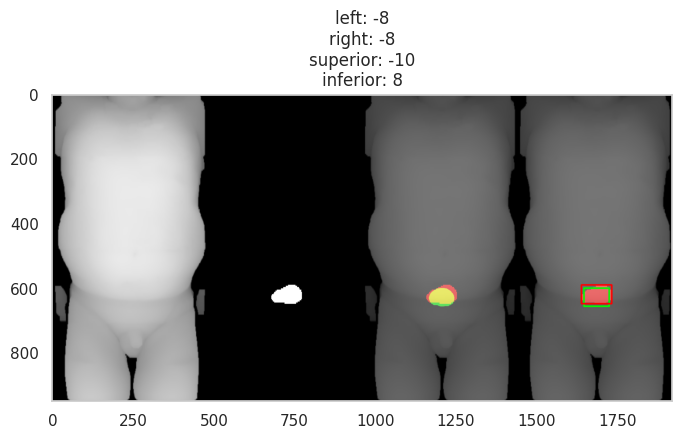

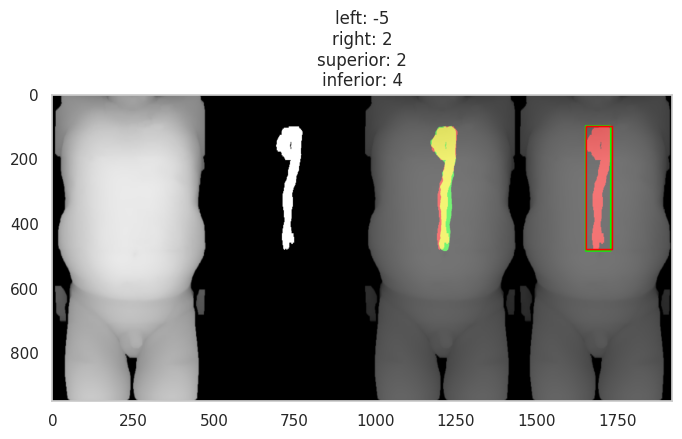

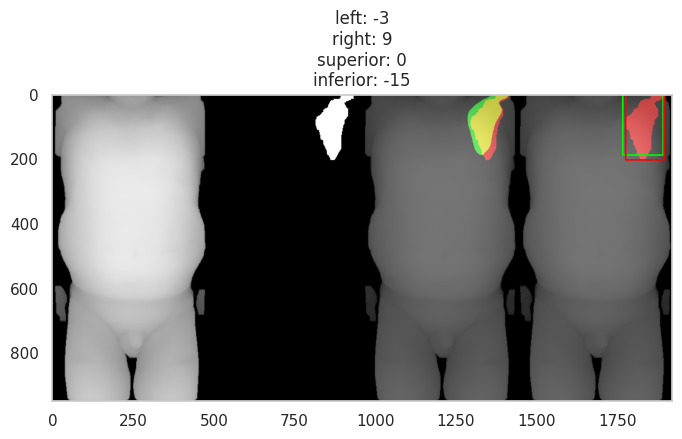

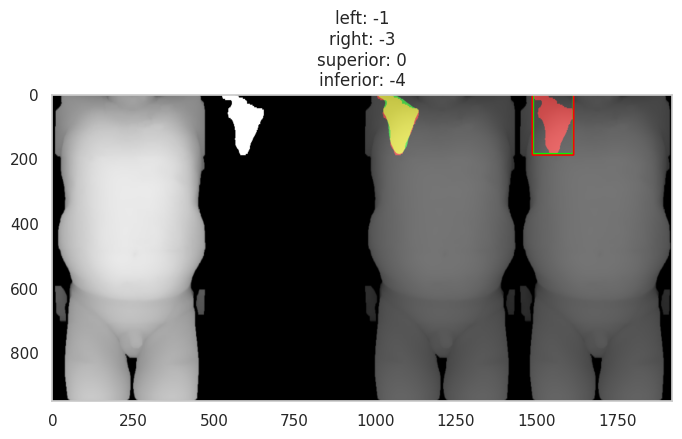

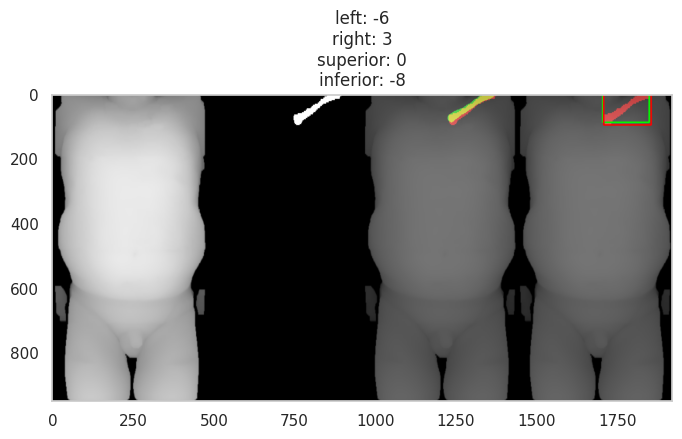

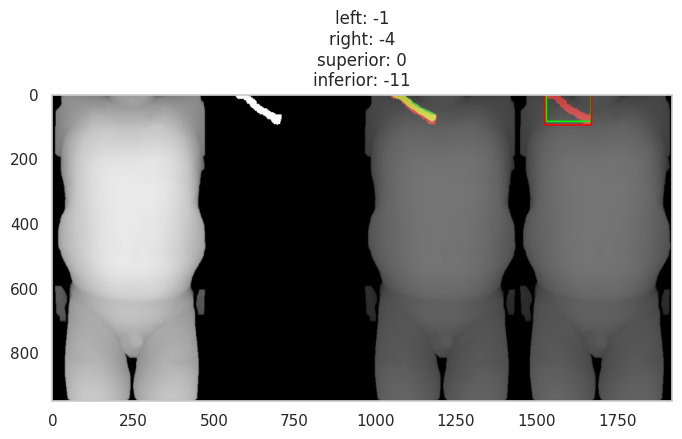

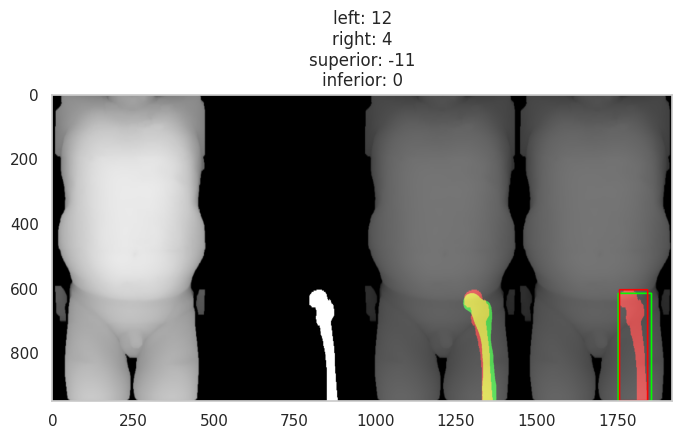

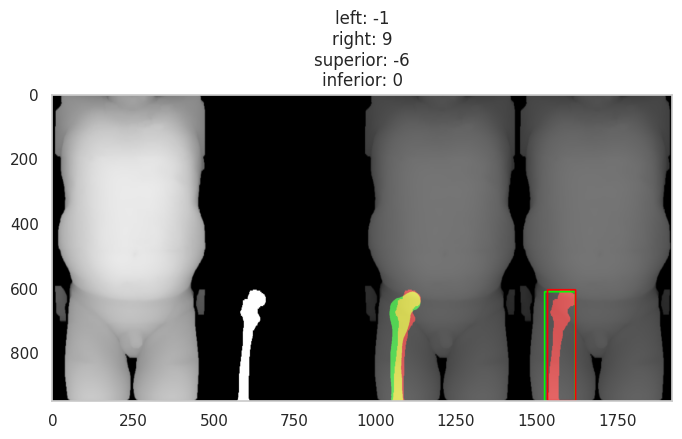

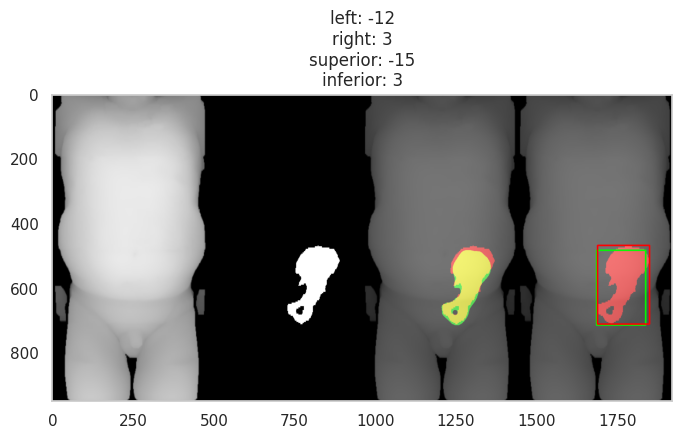

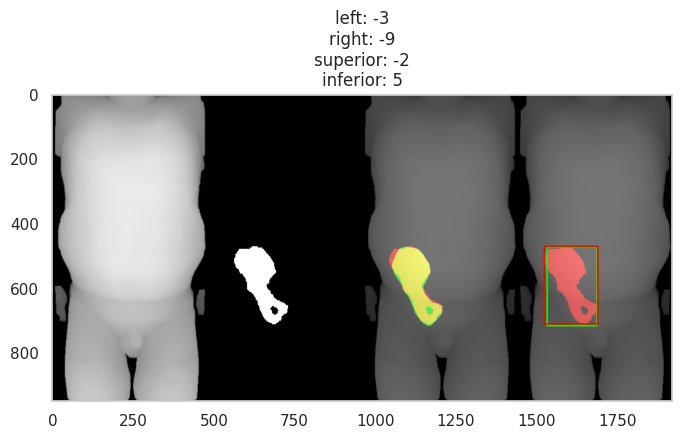

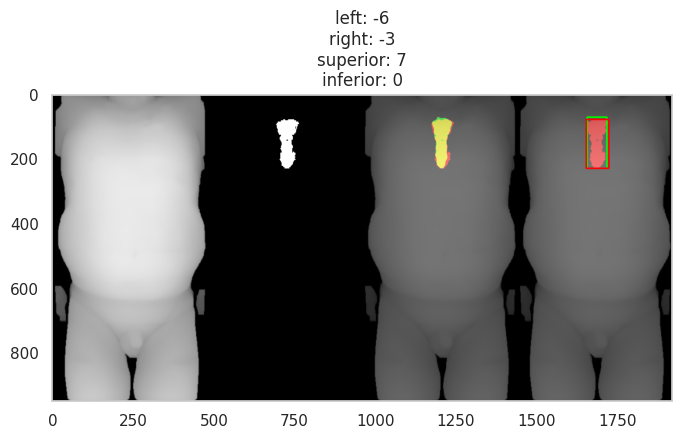

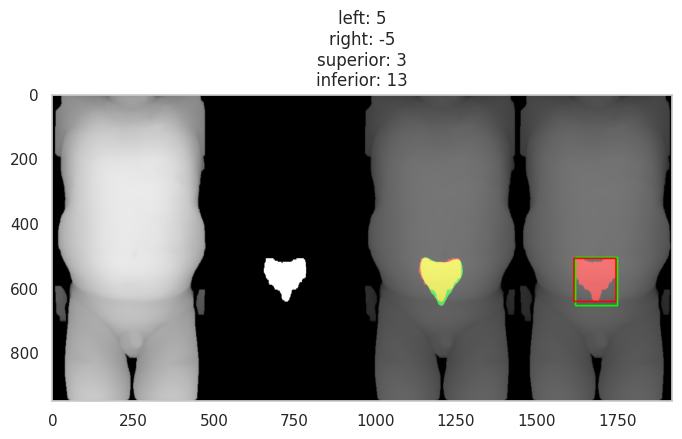

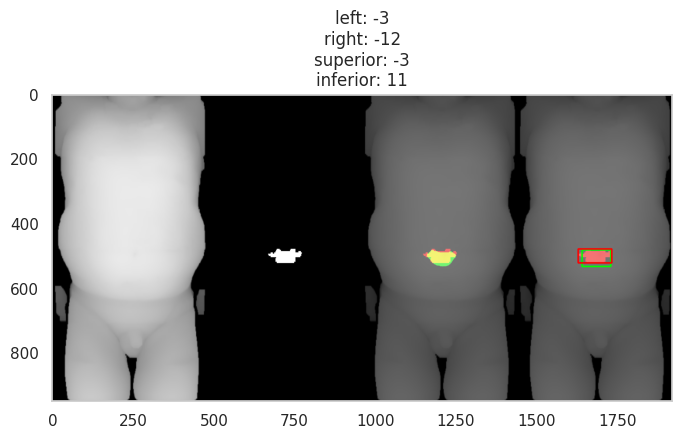

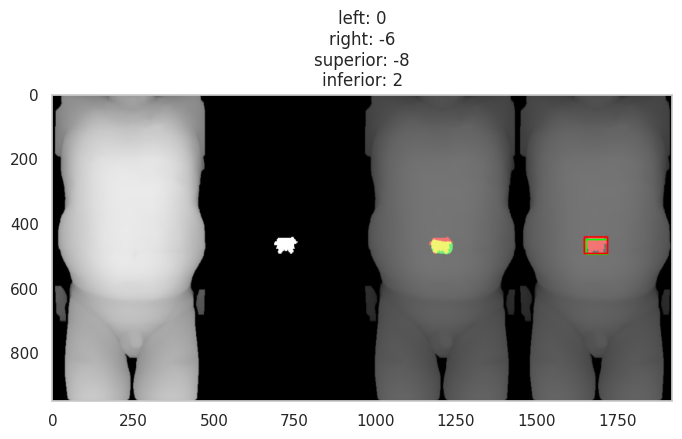

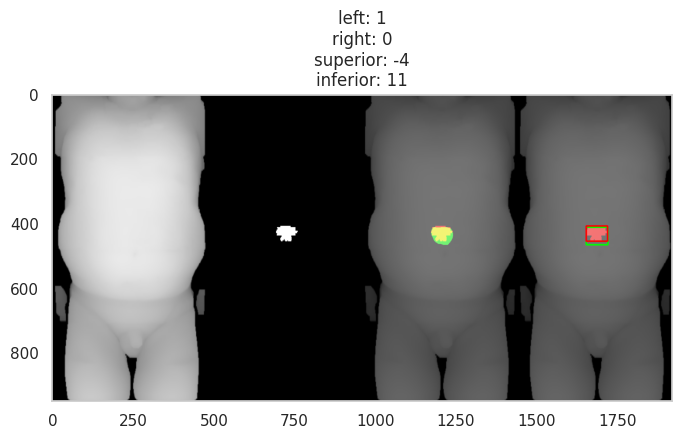

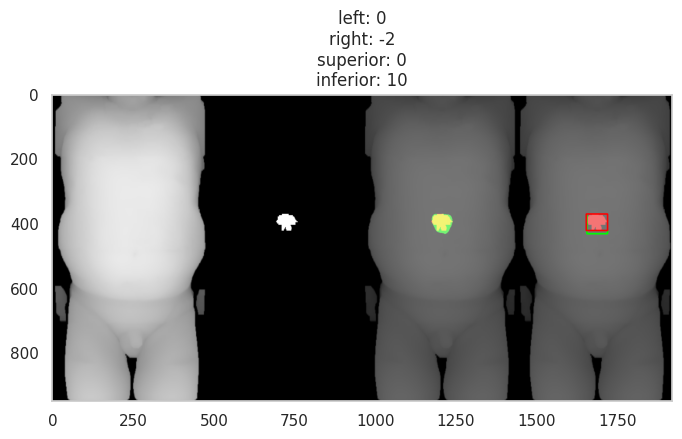

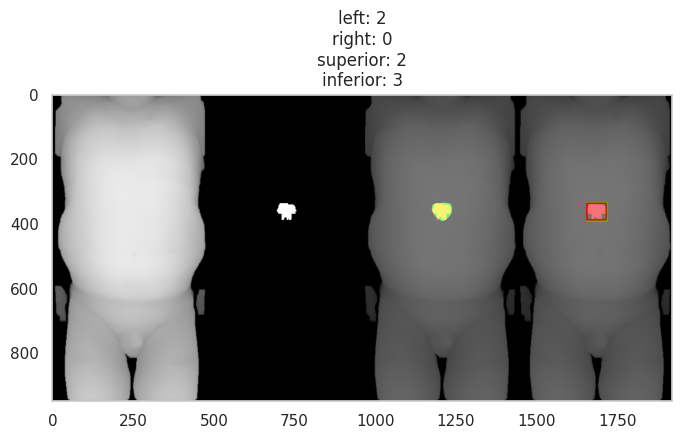

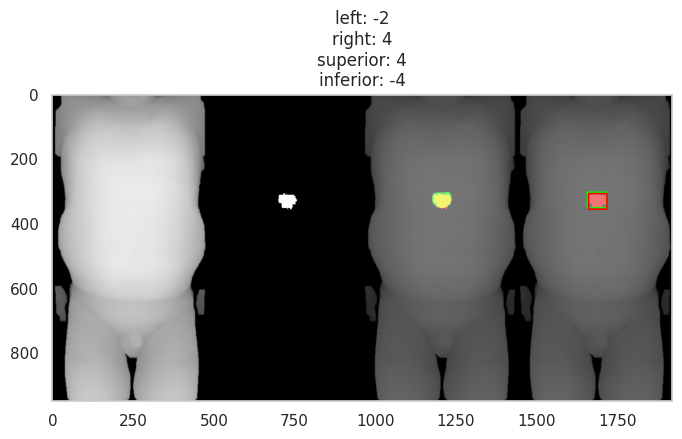

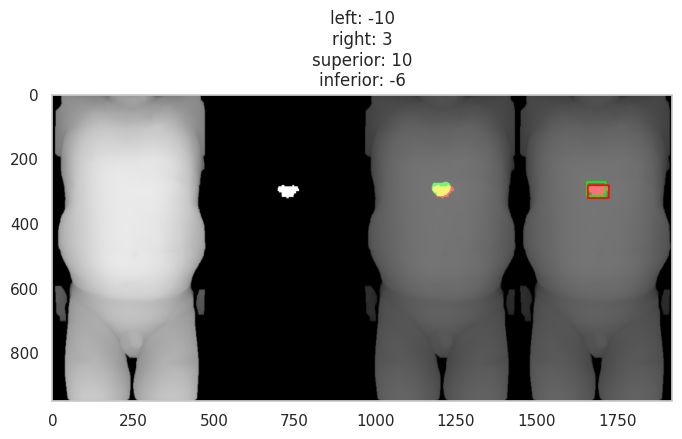

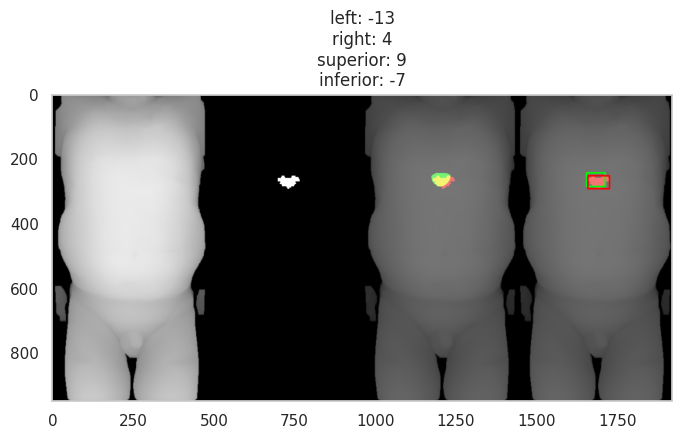

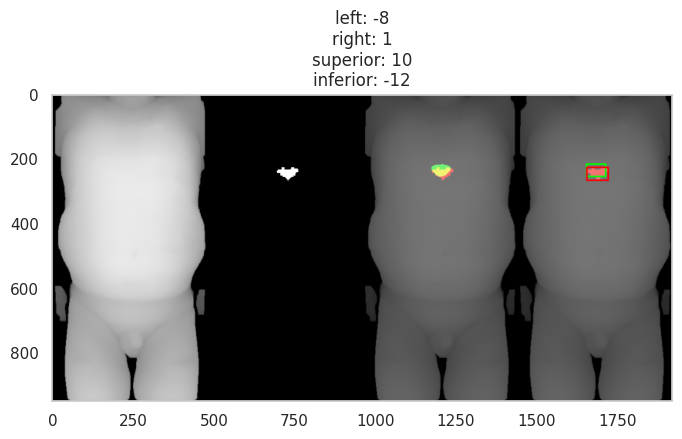

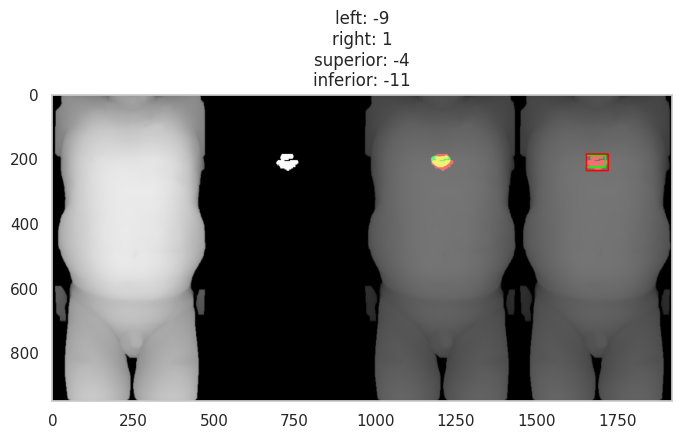

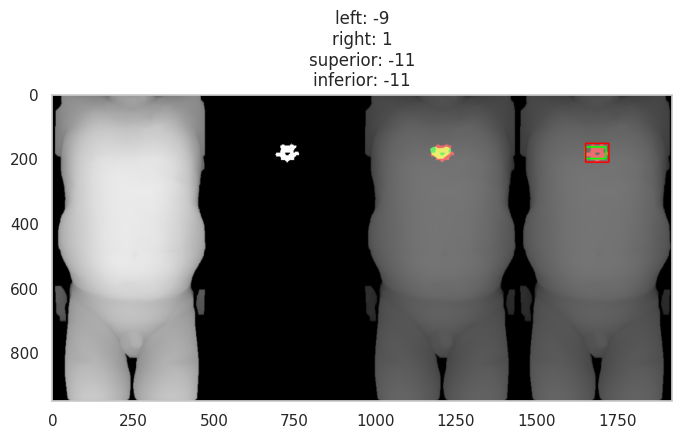

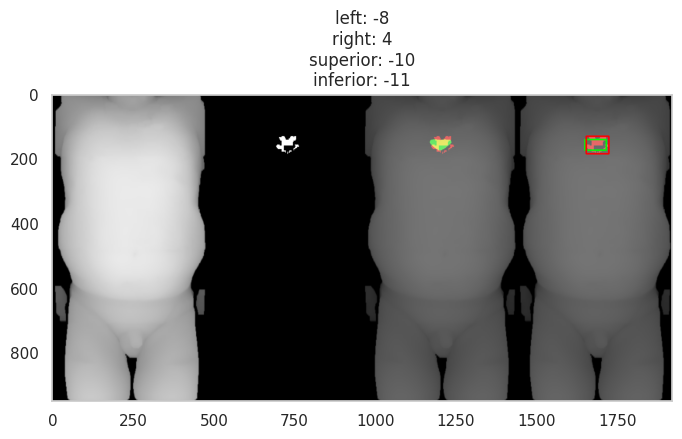

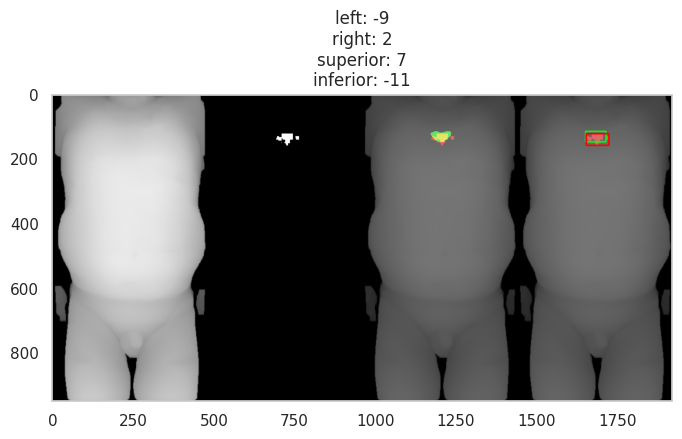

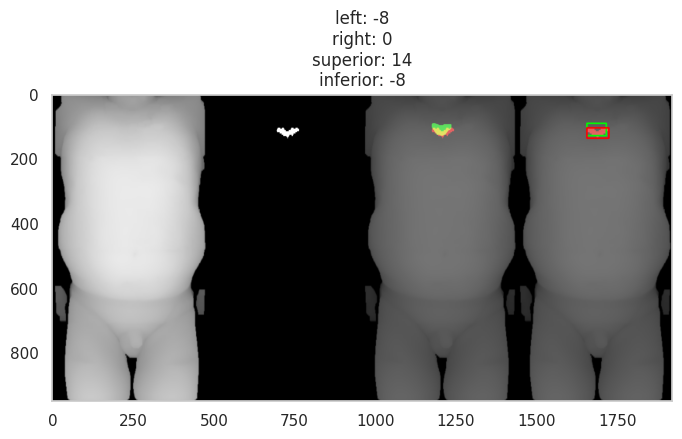

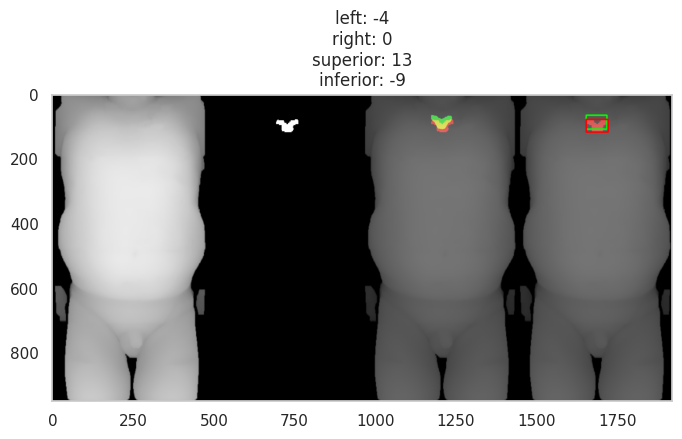

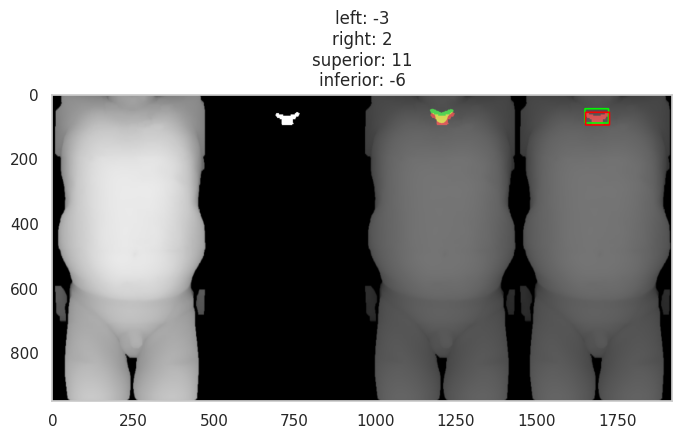

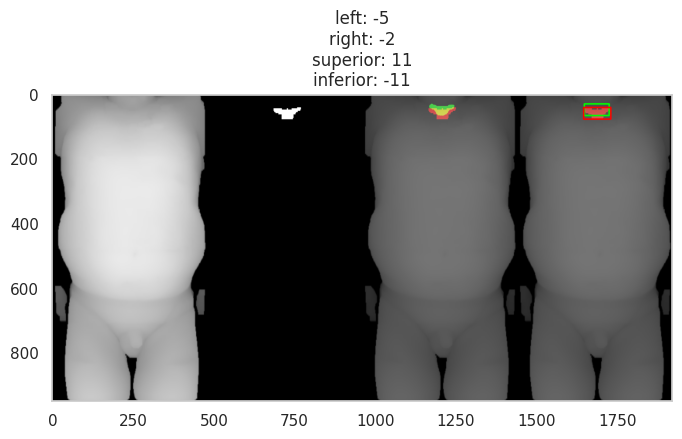

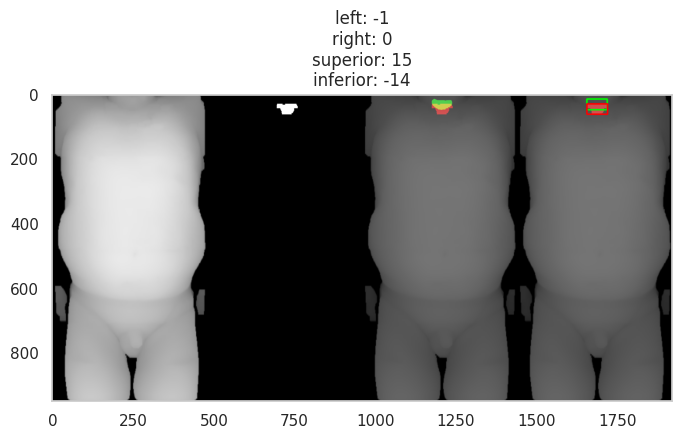

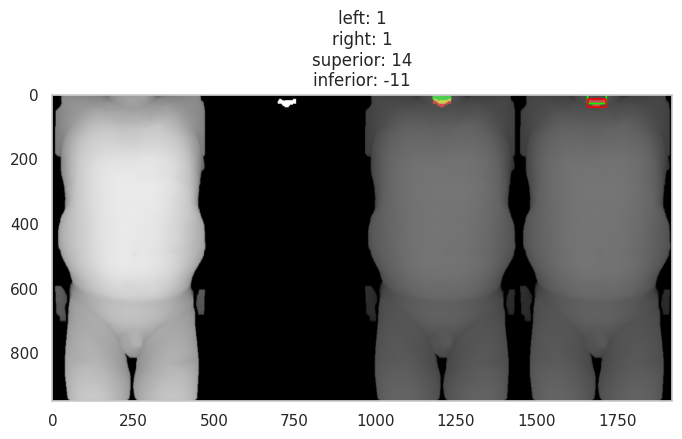

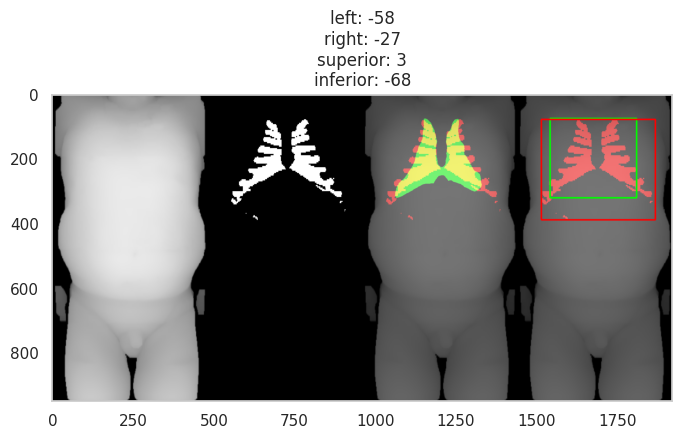

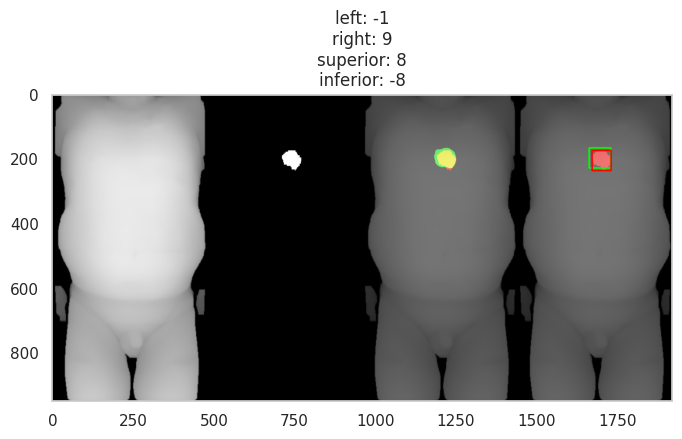

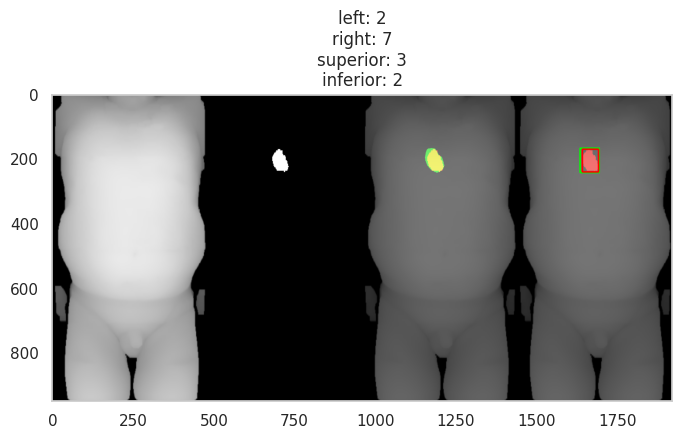

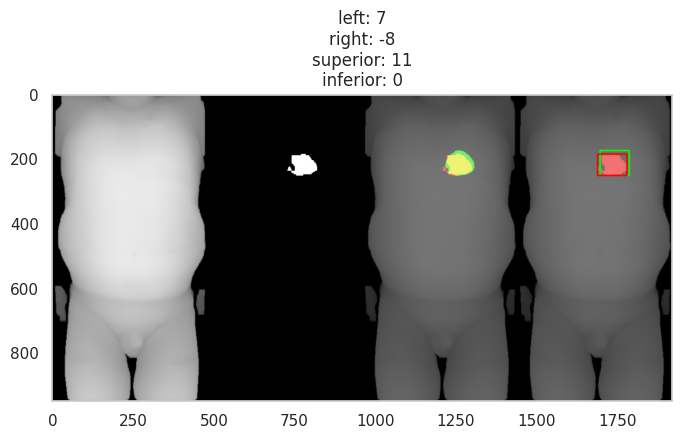

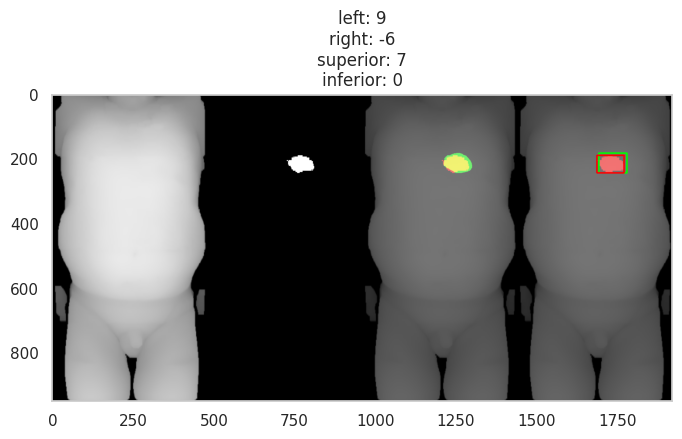

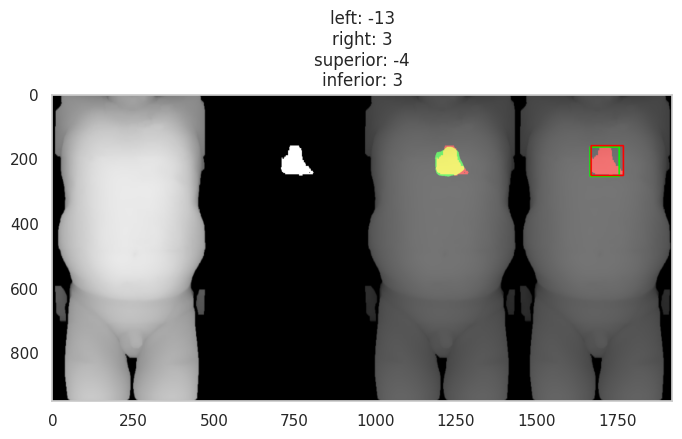

In [15]:
random_sample = df['name'].sample(n=1).iloc[0]
for anatomy in selected_organ_labels:
    visualize_results(random_sample, anatomy)

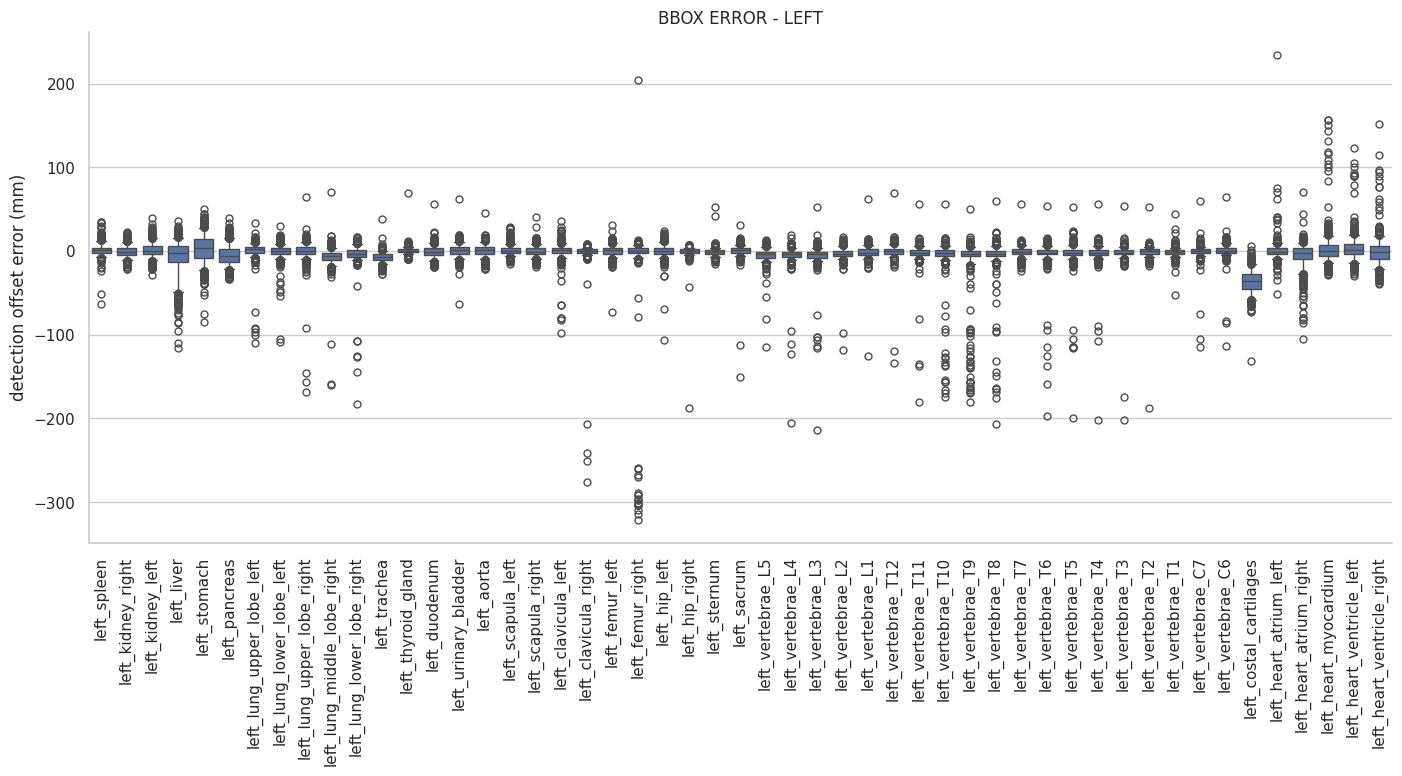

In [16]:
all_labels = [col for col in df.columns if col.startswith('left') and ('mean' not in col)]
all_cols = [col for col in df.columns if col.startswith('left') and ('mean' not in col)]
all_cols.append('experiment')
plot_results(df, all_cols, all_labels, "BBOX ERROR - LEFT", aspect_ratio=2.5, outliers=True)

In [8]:
def visualize_outliers(df, anatomy, side, ascending=True, vis_num=1):

    df_femur_right = df[['name', f'{side}_{anatomy}']]
    df_femur_right = df_femur_right.sort_values(by=f'{side}_{anatomy}', ascending=ascending)

    for idx in range(0, vis_num):
        visualize_results(df_femur_right.iloc[idx]['name'], anatomy)

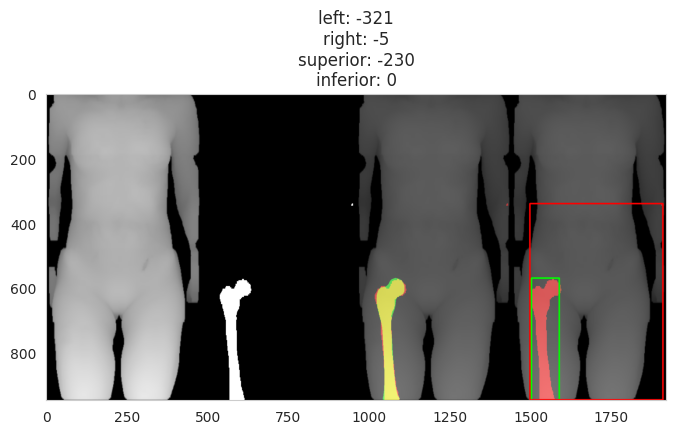

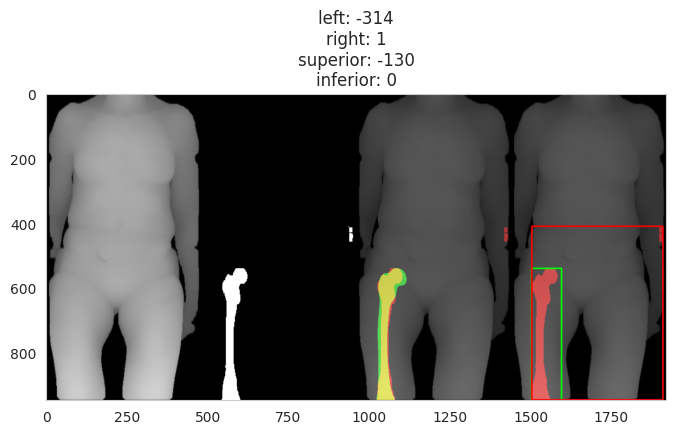

In [11]:
visualize_outliers(df, 'femur_right', 'left', ascending=True, vis_num=2)

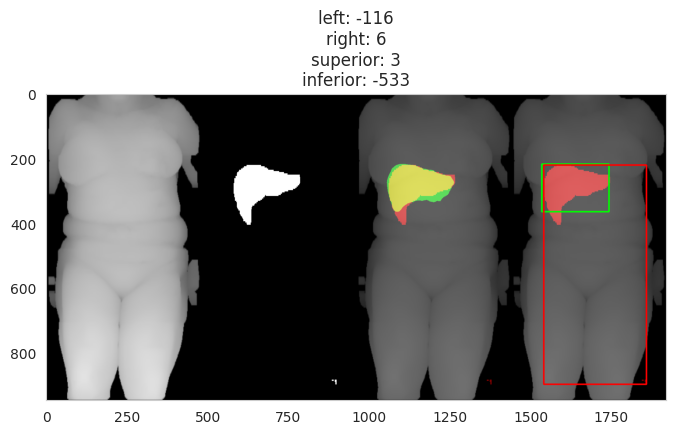

In [14]:
visualize_outliers(df, 'liver', 'left', ascending=True, vis_num=2)

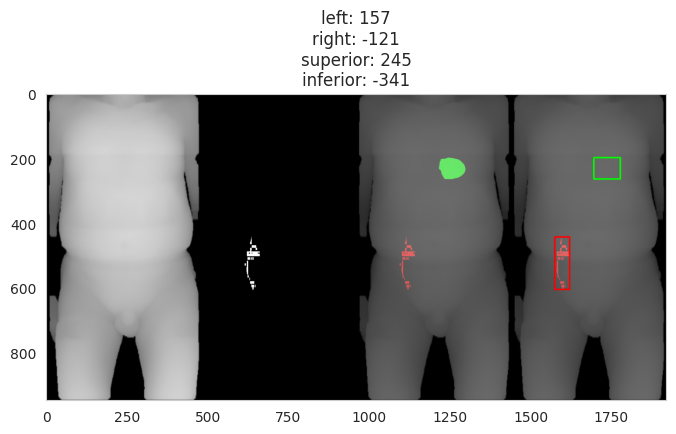

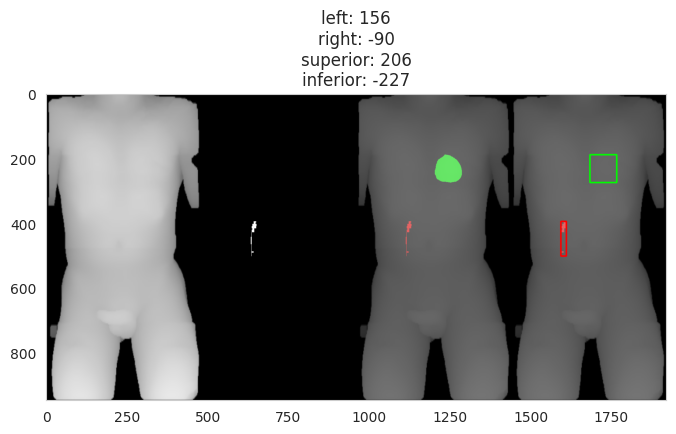

In [16]:
visualize_outliers(df, 'heart_myocardium', 'left', ascending=False, vis_num=2)

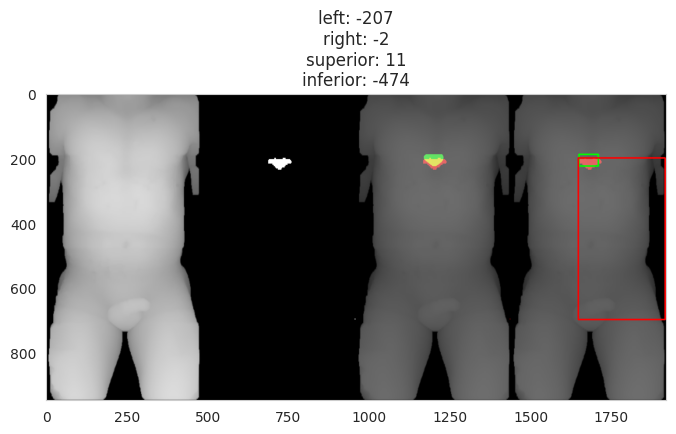

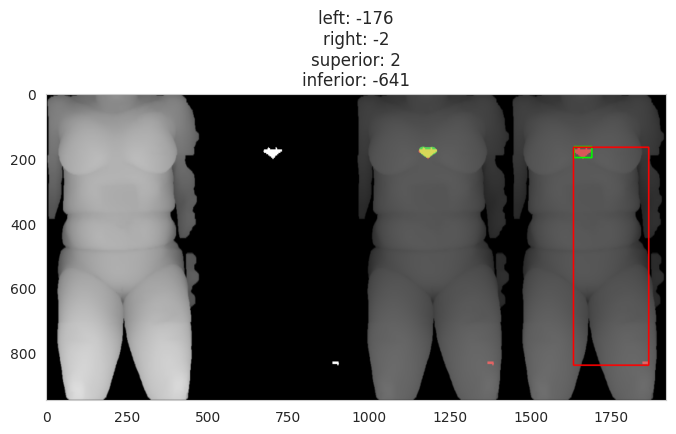

In [17]:
visualize_outliers(df, 'vertebrae_T8', 'left', ascending=True, vis_num=2)

# 🚀 Steps Forward

---

## 1. 📝 Journal Submission Preparation
**🗓 Deadline: July 15, 2025**

Key Tasks:
- ✅ **Increase organ group coverage**.
- ✅ **Expand to 3D**.

---

## 2. Internal Anatomy Localization: INR Approach
- Investigate the use of **Implicit Neural Representations (INR)** for internal structure detection.

---

## 3. Internal Anatomy Localization: Geometric Deep Learning (Salih)
- Explore **Geometric DL methods** for structure-aware modeling.
- Salih to lead this workstream with focus on graph-based models.

---

## 4. Large-Scale Self-Supervised Learning (SSL) Pretraining
- Scale up SSL across diverse anatomical scans.
- Use available labels to intorice semantic meaning.